# Ephemeris of Earth

Here, we numerically integrate the Earth’s orbit around the sun using the initial conditions from
https://ssd.jpl.nasa.gov/horizons.cgi#top- with ephemeris type “vectors”, target body “earth”,
and coordinate origin sun. 

In [1]:
#Run this to have interactive plots (slow)
#%matplotlib notebook 

#Regular plots
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint
from numpy.linalg import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#Define functions to take the norm and dot product batchwise to avoid for loops
dot_batch = lambda v1, v2: np.sum(v1*v2, axis=1)
norm_sq_batch = lambda v: dot_batch(v,v)
norm_batch = lambda v: np.sqrt(norm_sq_batch(v))

#Define constants used in the integration
m_s = 1.9885e30 #kg
m_e = 5.9722e24 #kg
M = m_e + m_s #kg
G = 6.6743e-11 #m^3 kg^-1 s^-2

#Initial position and velocity of the Earth in m and m/s respectively
x_earth0 = np.array([1.498994926947174e11, 6.157962886642456e9, -8.865554281636141e5])
v_earth0 = np.array([-1.701659572291657e3, 2.966166838386400e4, -2.224382206183151e0])

#Initial position of the center of mass before shifting to center of mass frame (x_sun0 = 0)
com = m_e*x_earth0/M

#Shift the initial coordinates of the earth and sun so that the center of mass is at (0,0,0)
x_earth0 -= com
x_sun0 = -com
v_sun0 = np.zeros(3)

#Velocity of the center of mass
v_com = (m_e*v_earth0 + m_s*v_sun0)/M

#Adjust the initial velocities of the earth and sun so that the velocity of the center of mass is zero
#This ensures the center of mass stays at the origin and we remain in the center of mass frame
v_earth0 -= v_com
v_sun0 -= v_com

#Initial energy
E0 = 0.5*(m_e*norm(v_earth0)**2 + m_s*norm(v_sun0)**2) - G*m_s*m_e/norm(x_earth0 - x_sun0)

#Initial position of center of mass (should be ~(0,0,0))
x_com0 = (m_e*x_earth0 + m_s*x_sun0)/M

#Initial condition vector
x_0 = np.concatenate((x_earth0, v_earth0, x_sun0, v_sun0, x_com0, [E0]))

#Define the time we want to integrate for
years = 10000
seconds_per_year = 60*60*24*365.2422
t = np.linspace(0, seconds_per_year*years, 250*years)

def earth_sun_system(x, t):
    x_earth, v_earth, x_sun, v_sun, x_com = x[:-1].reshape(5,3)
        
    #r is a vector from Earth to Sun
    r = x_sun - x_earth
    normr = norm(r)
    rhat = r/normr
    
    #Compute the accelerations of the Earth and Sun
    a_earth = G*m_s/(normr**2)*rhat
    a_sun = G*m_e/(normr**2)*(-rhat)
    
    #Compute the derivative of the energy to make sure total energy stays constant
    dUdt = G*m_e*m_s*np.dot(x_earth-x_sun, v_earth-v_sun)/norm(x_earth-x_sun)**3
    dEdt = m_e*np.dot(v_earth,a_earth) + m_s*np.dot(v_sun,a_sun) + dUdt
    
    #Compute the derivative of the position of center of mass (center of momentum)
    v_com = (m_e*v_earth + m_s*v_sun)/M
        
    #Return derivatives of the system variables
    #v_com and dEdt are verification variables
    return np.concatenate((v_earth, a_earth, v_sun, a_sun, v_com, [dEdt]))

#Solve the ODE
soln = odeint(earth_sun_system, x_0, t)

x_earth = soln[:,:3]
x_sun = soln[:,6:9]

energy = soln[:,-1]

x_com = soln[:,12:15]

print('Computation complete')

Computation complete


### Plot the orbits and energy:

(-0.00017954892998402612, 0.003770529162361157)

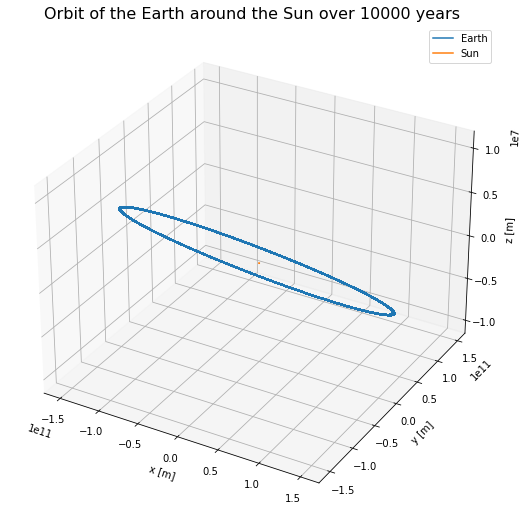

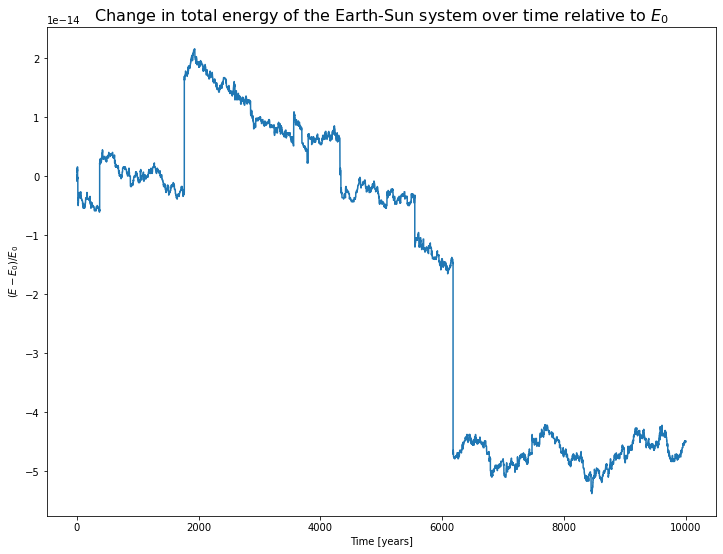

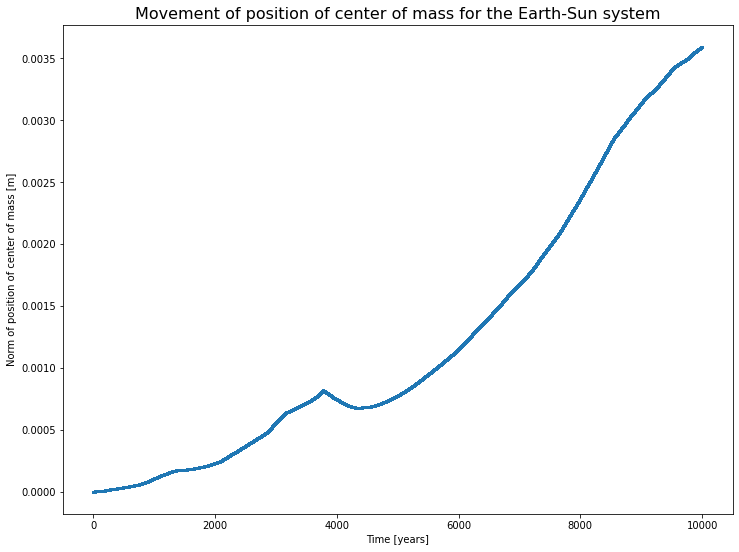

In [3]:
ppy = 40 #data points per year to plot
step = len(x_earth)//(ppy*years)

#Plot the orbits in 3D
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_earth[:,0][::step],x_earth[:,1][::step],x_earth[:,2][::step])
ax.plot(x_sun[:,0][::step],x_sun[:,1][::step],x_sun[:,2][::step])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Orbit of the Earth around the Sun over %d years' % years, fontsize=16)
ax.legend(('Earth','Sun'), loc='upper right')

#Plot the relative change in energy to ensure total energy is constant
plt.figure(figsize=(12,9))
E_relative = energy/E0 - 1
plt.plot(t/seconds_per_year, E_relative)
plt.xlabel('Time [years]')
plt.ylabel('$(E-E_0)/E_0$')
plt.title('Change in total energy of the Earth-Sun system over time relative to $E_0$', fontsize=16)
data_range = max(E_relative) - min(E_relative)
plt.ylim(min(E_relative) - 0.05*data_range, max(E_relative) + 0.05*data_range)

#Plot the modulus of the position of the center of mass to ensure it stays constant
plt.figure(figsize=(12,9))
norm_com = norm_batch(x_com)
plt.scatter(t/seconds_per_year, norm_com, s=2)
plt.xlabel('Time [years]')
plt.ylabel('Norm of position of center of mass [m]')
plt.title('Movement of position of center of mass for the Earth-Sun system', fontsize=16)
data_range = max(norm_com) - min(norm_com)
plt.ylim(min(norm_com) - 0.05*data_range, max(norm_com) + 0.05*data_range)

The relative change in energy shown in the plot above is on the order of $5 \times 10^{-14}$, which is near enough to 0 to attribute to numerical errors.  Similarly, the position of the center of mass changes by less than 10mm in 10000 years, which is also a consequence of numerical errors.  Thus, we can conclude that the position of the center of mass and the total energy are constant as they should be.

### Periods of orbit:
We first compute a vector orthogonal to the initial position vector x_earth0 of the Earth by taking the initial Earth velocity vector v_earth0 and removing the component in the direction of x_earth0.  This vector then defines a plane as a normal vector to that plane.  One orbit is complete when earth passes through this plane in the right direction.  To find when this happens, we dot this normal vector with the current Earth position vector x_earth and consider the sign.  When the sign changes from negative to positive, an orbit has been completed.

In [33]:
#Compute a vector in the circumferential direction of the earth's orbit at time 0
proj_v_earth0_onto_x_earth0 = np.dot(x_earth0,v_earth0)/np.dot(x_earth0,x_earth0)*x_earth0
normal_vec = v_earth0 - proj_v_earth0_onto_x_earth0  #normal to plane passing through (0,0,0) and x_earth0
dot_x_earth_with_normal_vec = np.sum(normal_vec*x_earth, axis=1)
sign_vec = np.sign(dot_x_earth_with_normal_vec)  #Earth passes through the plane when sign_vec changes sign

#Get the times when the earth completes a full orbit. These should be multiples of one year
t_orbit_indices = np.array([i for i in range(len(sign_vec)-1) if sign_vec[i] < 0 and sign_vec[i+1] > 0])
if t_orbit_indices[0] != 0:
    t_orbit_indices = np.concatenate((np.array([0]), t_orbit_indices))
t_orbit = t[t_orbit_indices]

periods = np.array([t_orbit[i+1]-t_orbit[i] for i in range(len(t_orbit)-1)])

mean_orbital_period = np.mean(periods)

print('Mean Orbital Period: %.5f years' % (mean_orbital_period/seconds_per_year))

Mean Orbital Period: 0.99446 years


### Perihelion and aphelion:
We can use the scipy.signal function find_peaks to get the local maxima and minima in the distance between the Earth and the Sun, which give the aphelia and perihelia.

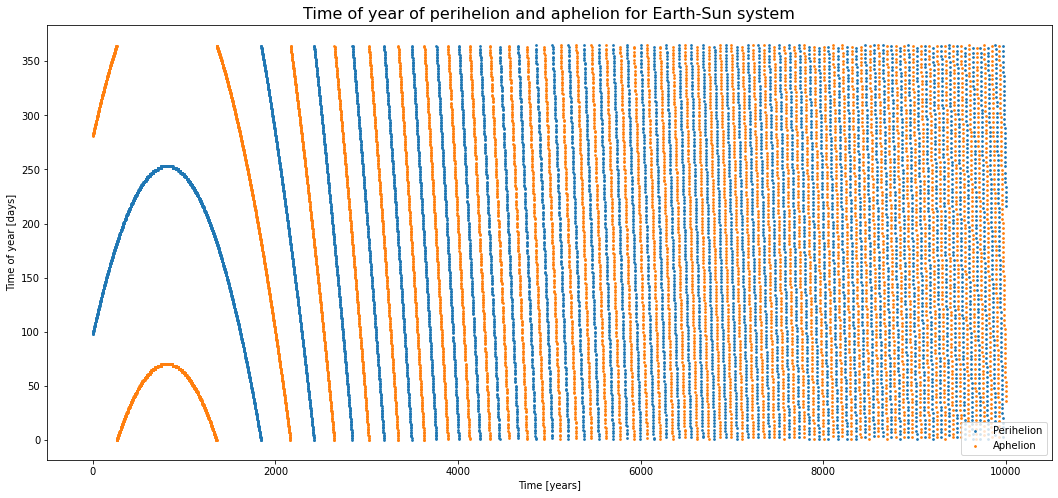

In [34]:
from scipy.signal import find_peaks

earth_sun_dist = norm_batch(x_earth-x_sun)

#Compute the indices of x_earth and t at which aphelia and perihelia occur
aph_indices = find_peaks(earth_sun_dist)[0]
peri_indices = find_peaks(-earth_sun_dist)[0]

#Plot the time of year of aphelia and perihelia as a function of time
plt.figure(figsize=(18,8))
plt.scatter(t[peri_indices]/seconds_per_year, np.mod(t[peri_indices], seconds_per_year)/seconds_per_year*365.2422, s=3)
plt.scatter(t[aph_indices]/seconds_per_year, np.mod(t[aph_indices], seconds_per_year)/seconds_per_year*365.2422, s=3)
plt.xlabel('Time [years]')
plt.ylabel('Time of year [days]')
plt.title('Time of year of perihelion and aphelion for Earth-Sun system', fontsize=16)
plt.legend(('Perihelion','Aphelion'))

### Eccentricity:
We use the same method to calculate apoapsides and periapsides of the orbit as we did to compute aphelia and perihelia.  The eccentricity is then given by $$e=\frac{r_a - r_p}{r_a + r_p}$$ where $r_a$ is the orbital radius at apoapsis and $r_p$ is the orbital radius at periapsis.

Text(0.5, 1.0, "Eccentricity of Earth's orbit around the Sun")

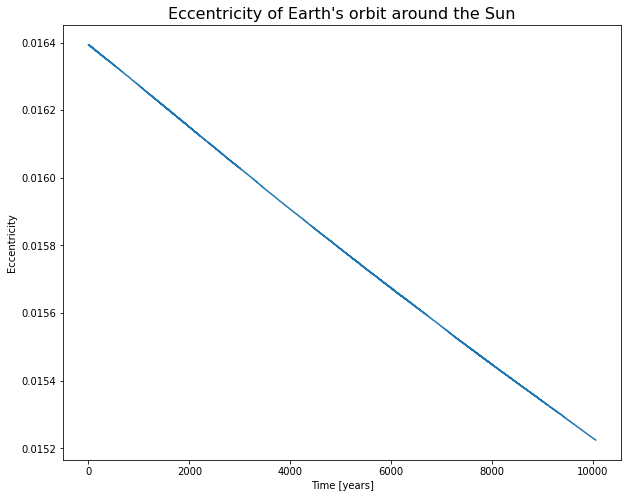

In [35]:
earth_focus_dist = norm_batch(x_earth)

#Find the indices giving apoapsides and periapsides in x_earth
apoapsis_indices = find_peaks(earth_focus_dist)[0]
periapsis_indices = find_peaks(-earth_focus_dist)[0]

#Sometimes apoapsis_indices and periapsis_indices differ in length by one, but they need to be the same length to compute eccentricity
if len(apoapsis_indices) != len(periapsis_indices):
    if len(apoapsis_indices) > len(periapsis_indices):
        apoapsis_indices = apoapsis_indices[:-1]
    else:
        periapsis_indices = periapsis_indices[:-1]

#Radii at apoapsis (furthest distance from center of mass) and periapsis (closest distance)
r_ap = norm_batch(x_earth[apoapsis_indices])
r_peri = norm_batch(x_earth[periapsis_indices])

#Compute the eccentricity
eccentricity = (r_ap - r_peri)/(r_ap + r_peri)

#Plot the eccentricity
plt.figure(figsize=(10,8))
plt.plot(range(len(eccentricity)), eccentricity)
data_range = max(eccentricity) - min(eccentricity)
plt.ylim(min(eccentricity) - 0.05*data_range, max(eccentricity) + 0.05*data_range)
plt.xlabel('Time [years]')
plt.ylabel('Eccentricity')
plt.title('Eccentricity of Earth\'s orbit around the Sun', fontsize=16)

### Solar-energy flux:
Next, we calculate and plot the solar-energy fluxes: a) for the entire earth and b) for the northern
hemisphere (Ignoring reflections, clouds, etc.). 


We first compute the power of the Sun using the Stefan-Boltzmann Equation.  The proportion of radiation emitted by the Sun hitting an area $A$ at distance $r$ from the sun is then $$P = \frac{A}{4\pi r^2}.$$  We multiply this by the power of the sun to get the energy hitting the area $A$ every second.

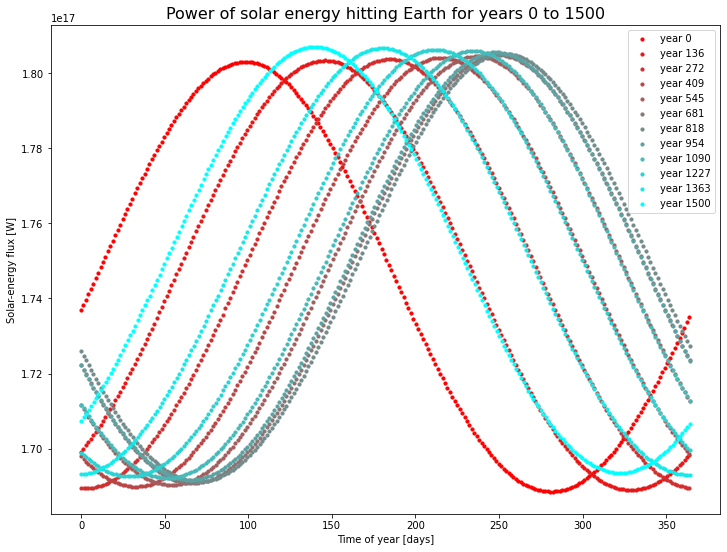

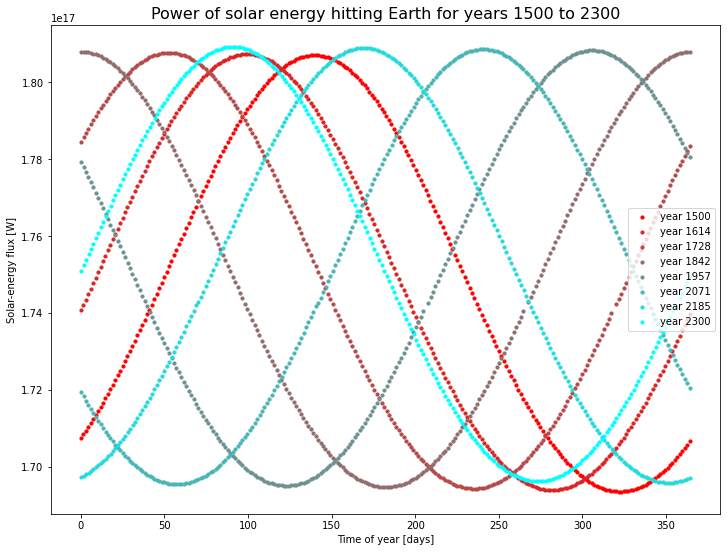

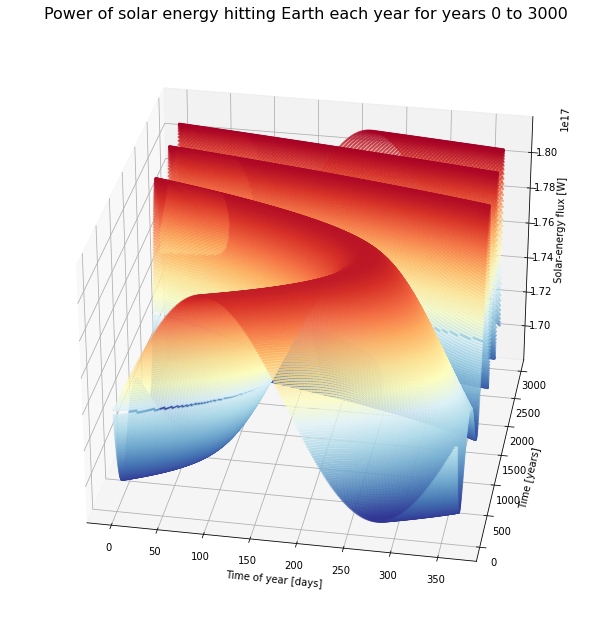

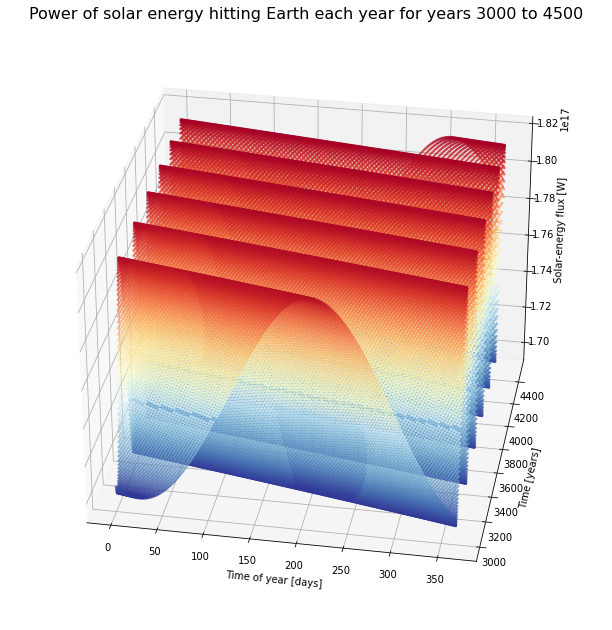

In [37]:
#The power of the Sun is given by the Stefan-Boltzmann Equation: P = epsilon*sigma*T^4*A
#For the Sun: epsilon = emissivity ~ 1; sigma = Stefan-Boltzmann constant = 5.670373e-8 W m^-2 K^-4;
#T = surface temperature = 5778 K; A = surface area = 4*pi*(6.957e8)^2 m
power_of_sun = 5.670373e-8 * 5778**4 * 4 * np.pi * 6.957e8**2 #Watts
earth_radius = 6.378e6 #m

#Since the radius of the Earth and Sun are much smaller than earth_sun_dist, we can approximate every point on Earth's
#surface as being earth_sun_dist away from the Sun's surface.

def SEflux(es_dist, sunlight_area):
    #Proportion of the radiation emitted by the Sun passing through every square meter at the distance of the Earth
    P = sunlight_area/(4*np.pi*es_dist**2) #m^-2

    #Solar-energy flux: Energy hitting the area sunlight_area at a distance es_dist from the Sun every second
    return power_of_sun*P #J/s

#Split the position vectors of the earth and sun into batches, one batch for each orbit
iterator = range(len(t_orbit_indices)-1)
x_earth_split_by_orbit = [x_earth[t_orbit_indices[i]:t_orbit_indices[i+1]] for i in iterator]
x_sun_split_by_orbit = [x_sun[t_orbit_indices[i]:t_orbit_indices[i+1]] for i in iterator]
t_split_by_orbit = [t[t_orbit_indices[i]:t_orbit_indices[i+1]] for i in iterator]

#Function to plot multiple years of flux on a 2d scatter-plot
def plot_flux_2d(start_year, end_year, n_plots):
    years_to_compute_flux = np.linspace(start_year,end_year,n_plots, dtype=int)

    plt.figure(figsize=(12,9))
    for i in years_to_compute_flux:
        earth_sun_dist = norm_batch(x_earth_split_by_orbit[i] - x_sun_split_by_orbit[i])
        #Compute the flux over the entire earth (Area = pi*R^2)
        SEflux_earth = SEflux(earth_sun_dist, np.pi*earth_radius**2)
        xdata = np.mod(t_split_by_orbit[i], seconds_per_year)/seconds_per_year*365.2422
        #Define a number to shift the color of the plots in time
        c_num = (i-start_year)/(end_year-start_year)
        #Plot the flux vs time of year on a scatter-plot
        plt.scatter(xdata, SEflux_earth, s=10, c=[[1-c_num,c_num,c_num]])
    plt.legend(['year ' + str(i) for i in years_to_compute_flux])
    plt.xlabel('Time of year [days]')
    plt.ylabel('Solar-energy flux [W]')
    plt.title('Power of solar energy hitting Earth for years %d to %d' % (start_year,end_year), fontsize=16)

plot_flux_2d(0,1500,12)    
plot_flux_2d(1500,2300,8)

#Function to plot a 3d plot of flux over time
def plot_flux_3d(start_year,end_year,year_step):

    #Compute the flux 
    X, Z = [], []
    for i in range(start_year,end_year):
        #X coordinate is the time of year in days
        X.append(np.mod(t_split_by_orbit[i], seconds_per_year)/seconds_per_year*365.2422)
        earth_sun_dist = norm_batch(x_earth_split_by_orbit[i] - x_sun_split_by_orbit[i])
        #Z coordinate is the flux
        Z.append(SEflux(earth_sun_dist, np.pi*earth_radius**2))
        
    #Make sure the lenghts of all elements of X and Z are the same
    minlen = min([len(x) for x in X] + [len(z) for z in Z])
    X = np.array([x[:minlen] for x in X])
    Z = np.array([z[:minlen] for z in Z])

    #Create colour map for the 3d plot where points are coloured by z-value
    cm = plt.get_cmap("RdYlBu_r")
    maxz = max(Z.flatten())
    minz = min(Z.flatten())
    col = cm((Z-minz)/(maxz-minz))

    #Plot the flux in 3D
    fig = plt.figure(figsize=(14,11))
    ax = fig.add_subplot(projection='3d')
    for i in range(0,len(X),year_step):
        ax.scatter(X[i], (i+start_year)*np.ones(len(X[i])), Z[i], s=3, c=col[i], alpha=0.6)
    ax.set_xlabel('Time of year [days]')
    ax.set_ylabel('Time [years]')
    ax.set_zlabel('Solar-energy flux [W]')
    ax.set_title('Power of solar energy hitting Earth each year for years %d to %d' % (start_year,end_year), fontsize=16)
    
    #Set the viewing angle of the 3d plot
    ax.view_init(elev=30, azim=-80)
    
plot_flux_3d(0,3000,4)
plot_flux_3d(3000,4500,3)

If the Earth's axis is tilted at angle $\theta$ toward from the Sun, a half-ellipse of area $\frac{1}{2}\pi\cdot r \cdot r\sin\theta$ in the northern hemisphere is exposed to sunlight, so the total area in the northern hemisphere exposed to sunlight is $\frac{1}{2}\pi r^2 + \frac{1}{2}\pi r^2 \sin\theta = \frac{1}{2}\pi r^2(1+\sin\theta)$.  Similarly, if Earth's axis is tilted at angle $\theta$ $\textit{away}$ from the Sun, the area of the northern hemisphere exposed to sunlight is $\frac{1}{2}\pi r^2(1-\sin\theta)$.

The angle $\theta$ the Earth is tilted toward the Sun oscillates sinusoidally with the same period as the orbital period, and reaches a maximum and minimum at summer and winter solstice respectively.  Thus, we define a function of the form $$\theta(t) = A\cos(\omega t + \phi)$$ where $A, \omega,$ and $\phi$ are computed appropriately.  The axial tilt $A$ is the angle between the normal of the Earth's orbital plane and the Earth's axis.  This oscillates between $22.1^\circ$ and $24.5^\circ$ roughly every 41000 years, so we also account for this through another sinusoidal function.

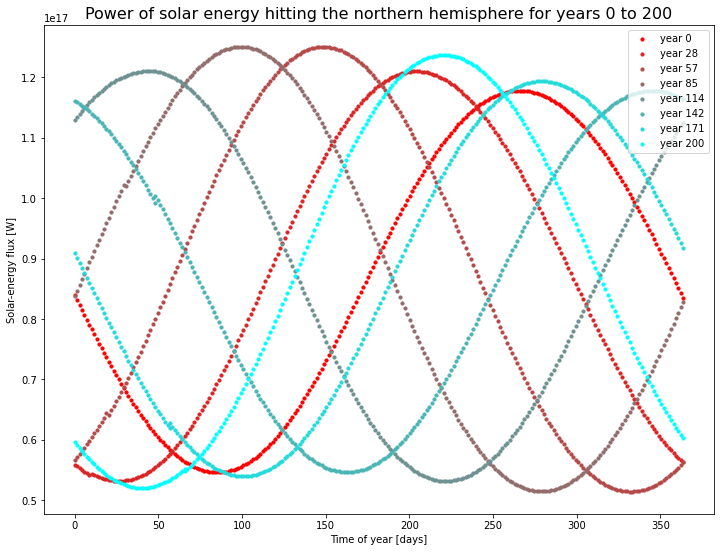

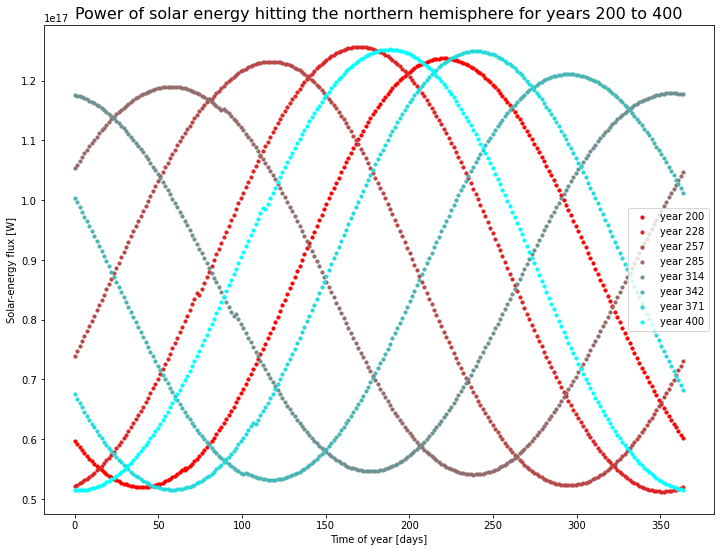

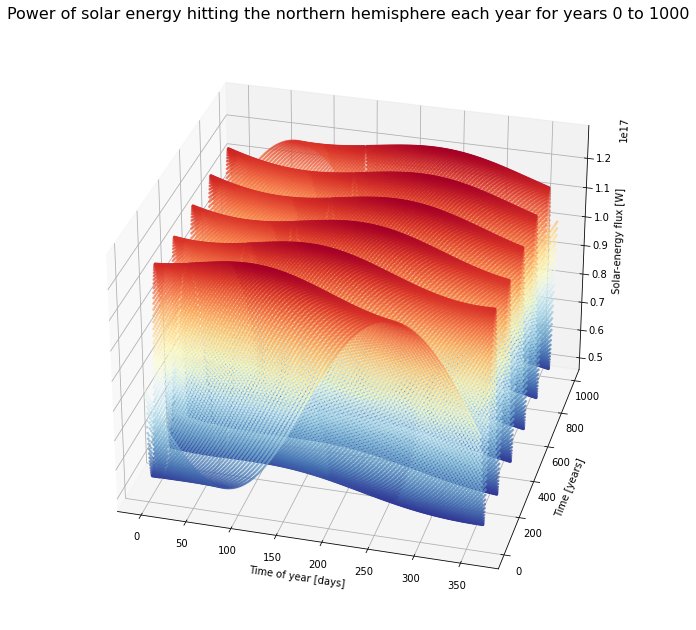

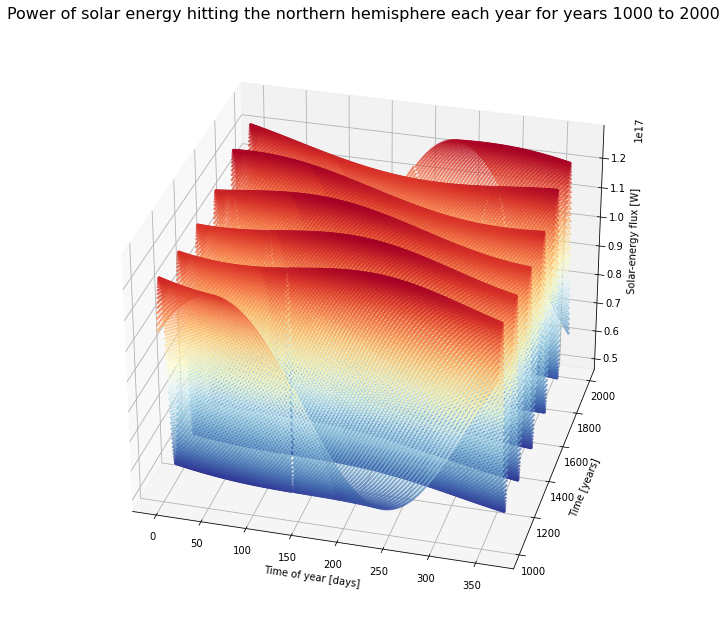

In [61]:
#Angle between the Earth's axis and the Earth-Sun plane
#axial_tilt oscillates between 22.1 deg and 24.5 deg on a 41000 year cycle
axial_tilt_now = 23.439291*np.pi/180
max_tilt = 24.5*np.pi/180
min_tilt = 22.1*np.pi/180
avg_tilt = 0.5*(max_tilt + min_tilt)
tilt_freq = 2*np.pi/(41000*seconds_per_year)
phi = np.arccos(2*(axial_tilt_now - avg_tilt)/(max_tilt - min_tilt)) #Calculated to satisfy axial_tilt(0) = axial_tilt_now
amplitude = (max_tilt-min_tilt)/2
def axial_tilt(t):
    return amplitude*np.cos(tilt_freq*t + phi) + avg_tilt

#Angle of Earth's axis toward or away from the sun
#Over the course of one orbit, this oscillates between +axial_tilt and -axial_tilt
t_ws = 86*24*60**2 #Winter solstice occurs roughly 86 days from t=0
angle_freq = 2*np.pi/mean_orbital_period
phi = np.pi - angle_freq*t_ws #Calculated to satisfy axis_angle(t_ws) = -axial_tilt(t_ws)
def axis_angle(t):
    return axial_tilt(t)*np.cos(angle_freq*t + phi)

#Function to plot multiple years of flux on a 2d scatter-plot
def plot_flux_2d(start_year, end_year, n_plots):
    years_to_compute_flux = np.linspace(start_year,end_year,n_plots, dtype=int)

    plt.figure(figsize=(12,9))
    for i in years_to_compute_flux:
        earth_sun_dist = norm_batch(x_earth_split_by_orbit[i] - x_sun_split_by_orbit[i])
        #Compute the flux over the northern hemisphere (Area = 0.5*(1+sin(theta))*pi*R^2)
        SEflux_nh = SEflux(earth_sun_dist, 0.5*(1+np.sin(axis_angle(t_split_by_orbit[i])))*np.pi*earth_radius**2)
        xdata = np.mod(t_split_by_orbit[i], seconds_per_year)/seconds_per_year*365.2422
        #Define a number to shift the color of the plots in time
        c_num = (i-start_year)/(end_year-start_year)
        #Plot the flux vs time of year on a scatter-plot
        plt.scatter(xdata, SEflux_nh, s=10, c=[[1-c_num,c_num,c_num]])
    plt.legend(['year ' + str(i) for i in years_to_compute_flux])
    plt.xlabel('Time of year [days]')
    plt.ylabel('Solar-energy flux [W]')
    plt.title('Power of solar energy hitting the northern hemisphere for years %d to %d' % (start_year,end_year), fontsize=16)

plot_flux_2d(0,200,8)    
plot_flux_2d(200,400,8)

#Function to plot a 3d plot of flux over time
def plot_flux_3d(start_year,end_year,year_step):

    #Compute the flux
    X, Z = [], []
    for i in range(start_year,end_year):
        #X coordinate is the time of year in days
        X.append(np.mod(t_split_by_orbit[i], seconds_per_year)/seconds_per_year*365.2422)
        earth_sun_dist = norm_batch(x_earth_split_by_orbit[i] - x_sun_split_by_orbit[i])
        #Z coordinate is the flux
        Z.append(SEflux(earth_sun_dist, 0.5*(1+np.sin(axis_angle(t_split_by_orbit[i])))*np.pi*earth_radius**2))
    
    #Make sure the lenghts of all elements of X and Z are the same
    minlen = min([len(x) for x in X] + [len(z) for z in Z])
    X = np.array([x[:minlen] for x in X])
    Z = np.array([z[:minlen] for z in Z])

    #Create colour map for the 3d plot where points are coloured by z-value
    cm = plt.get_cmap("RdYlBu_r")
    maxz = max(Z.flatten())
    minz = min(Z.flatten())
    col = cm((Z-minz)/(maxz-minz))

    #Plot the flux in 3D
    fig = plt.figure(figsize=(14,11))
    ax = fig.add_subplot(projection='3d')
    for i in range(0,len(X),year_step):
        ax.scatter(X[i], (i+start_year)*np.ones(len(X[i])), Z[i], s=3, c=col[i], alpha=0.6)
    ax.set_xlabel('Time of year [days]')
    ax.set_ylabel('Time [years]')
    ax.set_zlabel('Solar-energy flux [W]')
    ax.set_title('Power of solar energy hitting the northern hemisphere each year for years %d to %d' % (start_year,end_year), fontsize=16)
    
    #Set the viewing angle of the 3d plot
    ax.view_init(elev=30, azim=-75)
    
plot_flux_3d(0,1000,2)
plot_flux_3d(1000,2000,2)

### Adding Jupiter:

Now we add Jupiter to calculate the three body system and compare the Earth’s orbit and the solar
fluxes to those we get without Jupiter present.

Nearly all calculations are the same as in the Earth-Sun system, the main differences being in the initial computation of the orbit, where we have to add more terms into the computation of the accelerations and energy.

In [62]:
m_j = 1.89813e27 #kg
M = m_e + m_s + m_j

#Initial position and velocity of Jupiter in m and m/s respectively
X_earth0 = np.array([1.498994926947174e11, 6.157962886642456e9, -8.865554281636141e5])
V_earth0 = np.array([-1.701659572291657e3, 2.966166838386400e4, -2.224382206183151e0])
X_jup0 = np.array([-2.943869242562057e10, -7.866905829244311e11, 3.926273375257790e9])
V_jup0 = np.array([1.291304383091439e4, 1.259227587673614e2, -2.894962237877046e2])

#Initial position of the center of mass before shifting to center of mass frame (X_sun0 = 0)
Com = (m_e*X_earth0 + m_j*X_jup0)/M

#Shift the initial coordinates of the earth and sun so that the center of mass is at (0,0,0)
X_earth0 -= Com
X_jup0 -= Com
X_sun0 = -Com
V_sun0 = np.zeros(3)

#Velocity of the center of mass
V_com = (m_e*V_earth0 + m_s*V_sun0 + m_j*V_jup0)/M

#Adjust the initial velocities of the earth and sun so that the velocity of the center of mass is zero
#This ensures the center of mass stays at the origin and we remain in the center of mass frame
V_earth0 -= V_com
V_sun0 -= V_com
V_jup0 -= V_com

#Initial energy
T0 = 0.5*(m_e*norm(V_earth0)**2 + m_s*norm(V_sun0)**2 + m_j*norm(V_jup0)**2) 
U0 = -G*(m_s*m_e/norm(X_earth0 - X_sun0) + m_e*m_j/norm(X_earth0 - X_jup0) + m_s*m_j/norm(X_sun0 - X_jup0))
E_0 = T0 + U0

#Initial position of center of mass (should be ~(0,0,0))
X_com0 = (m_e*X_earth0 + m_s*X_sun0 + m_j*X_jup0)/M

#Initial condition vector
X_0 = np.concatenate((X_earth0, V_earth0, X_sun0, V_sun0, X_jup0, V_jup0, X_com0, [E_0]))

#Define the time we want to integrate for
Years = 10000
T = np.linspace(0, seconds_per_year*Years, 250*Years)

def earth_sun_jup_system(x, t):
    x_earth, v_earth, x_sun, v_sun, x_jup, v_jup, x_com = x[:-1].reshape(7,3)
    
    #Vectors between bodies
    r_es = x_sun - x_earth
    normr_es = norm(r_es)
    r_es_hat = r_es/normr_es
    
    r_ej = x_jup - x_earth
    normr_ej = norm(r_ej)
    r_ej_hat = r_ej/normr_ej
    
    r_js = x_sun - x_jup
    normr_js = norm(r_js)
    r_js_hat = r_js/normr_js
        
    #Compute the accelerations of the Earth, Sun, and Jupiter
    a_earth = G*m_s/(normr_es**2)*r_es_hat + G*m_j/(normr_ej**2)*r_ej_hat
    a_sun = G*m_e/(normr_es**2)*(-r_es_hat) + G*m_j/(normr_js**2)*(-r_js_hat)
    a_jup = G*m_e/(normr_ej**2)*(-r_ej_hat) + G*m_s/(normr_js**2)*r_js_hat
        
    #Compute the derivative of the energy to make sure total energy stays constant
    dUdt_es = G*m_e*m_s*np.dot(x_earth-x_sun, v_earth-v_sun)/norm(x_earth-x_sun)**3 
    dUdt_ej = G*m_e*m_j*np.dot(x_earth-x_jup, v_earth-v_jup)/norm(x_earth-x_jup)**3
    dUdt_js = G*m_j*m_s*np.dot(x_jup-x_sun, v_jup-v_sun)/norm(x_jup-x_sun)**3
    dTdt = m_e*np.dot(v_earth,a_earth) + m_s*np.dot(v_sun,a_sun) + m_j*np.dot(v_jup,a_jup)
        
    dEdt = dTdt + dUdt_es + dUdt_ej + dUdt_js
    
    #Derivative of the position of the center of mass
    v_com = (m_e*v_earth + m_s*v_sun + m_j*v_jup)/M
        
    #Return derivatives of the system variables
    #v_com and dEdt are verification variables
    return np.concatenate((v_earth, a_earth, v_sun, a_sun, v_jup, a_jup, v_com, [dEdt]))

#Solve the ODE
soln = odeint(earth_sun_jup_system, X_0, T)

X_earth = soln[:,:3]
X_sun = soln[:,6:9]
X_jup = soln[:,12:15]

Energy = soln[:,-1]

X_com = soln[:,18:21]

print('Computation complete')

Computation complete


### Plot the orbits and energy:

(-0.010833707840632301, 0.2275112043351989)

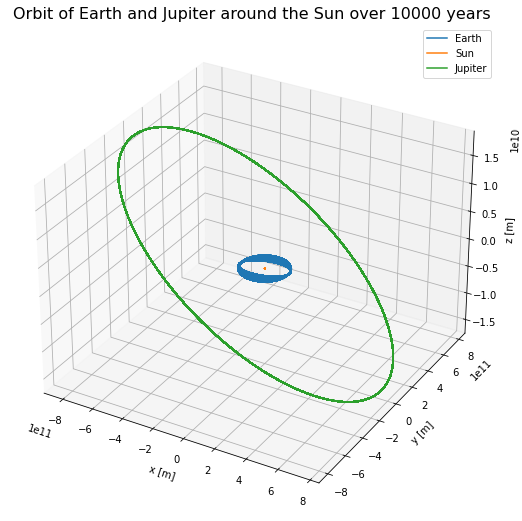

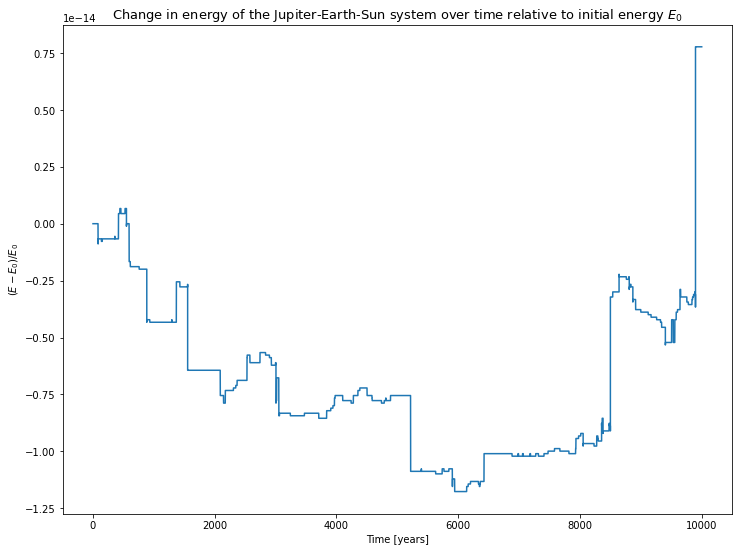

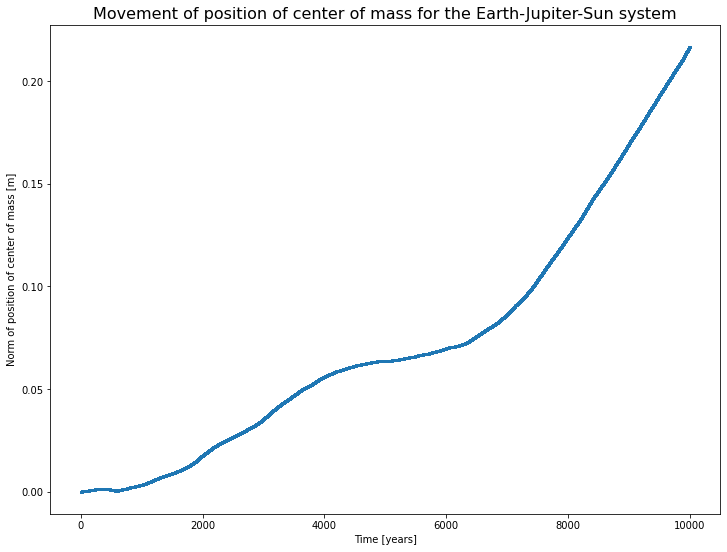

In [63]:
ppy = 40 #data points per year to plot
Step = len(X_earth)//(ppy*Years)

#Plot the orbits in 3D
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(X_earth[:,0][::Step], X_earth[:,1][::Step], X_earth[:,2][::Step])
ax.plot(X_sun[:,0][::Step], X_sun[:,1][::Step], X_sun[:,2][::Step])
ax.plot(X_jup[:,0][::Step], X_jup[:,1][::Step], X_jup[:,2][::Step])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Orbit of Earth and Jupiter around the Sun over %d years' % Years, fontsize=16)
ax.legend(('Earth','Sun','Jupiter'), loc='upper right')

#Plot the relative change in energy to ensure total energy is constant
plt.figure(figsize=(12,9))
E_Relative = Energy/E_0 - 1
plt.plot(T/seconds_per_year, E_Relative)
plt.xlabel('Time [years]')
plt.ylabel('$(E-E_0)/E_0$')
plt.title('Change in energy of the Jupiter-Earth-Sun system over time relative to initial energy $E_0$', fontsize=13)
Data_range = max(E_Relative) - min(E_Relative)
plt.ylim(min(E_Relative) - 0.05*Data_range, max(E_Relative) + 0.05*Data_range)

#Plot the modulus of the position of the center of mass to ensure it stays constant
plt.figure(figsize=(12,9))
Norm_com = norm_batch(X_com)
plt.scatter(T/seconds_per_year, Norm_com, s=2)
plt.xlabel('Time [years]')
plt.ylabel('Norm of position of center of mass [m]')
plt.title('Movement of position of center of mass for the Earth-Jupiter-Sun system', fontsize=16)
Data_range = max(Norm_com) - min(Norm_com)
plt.ylim(min(Norm_com) - 0.05*Data_range, max(Norm_com) + 0.05*Data_range)

Again, we see that the total energy and position of the center of mass don't change significantly over the course of 10000 years, which suggests that the physics and calculations have been done correctly and the deviation is due to numerical errors.

### Period of orbit:
Computation is the same as in the Earth-Sun system.

In [67]:
#Compute a vector in the circumferential direction of the earth's orbit at time 0
Proj_v_earth0_onto_x_earth0 = np.dot(X_earth0,V_earth0)/np.dot(X_earth0,X_earth0)*X_earth0
Normal_vec = V_earth0 - Proj_v_earth0_onto_x_earth0  #normal to plane passing through (0,0,0) and x_earth0
Dot_x_earth_with_normal_vec = np.sum(Normal_vec*X_earth, axis=1)
Sign_vec = np.sign(Dot_x_earth_with_normal_vec)  #Earth passes through the plane when sign_vec changes sign

#Get the times when the earth completes a full orbit. These should be multiples of one year
T_orbit_indices = np.array([i for i in range(len(Sign_vec)-1) if Sign_vec[i] < 0 and Sign_vec[i+1] > 0])
if T_orbit_indices[0] != 0:
    T_orbit_indices = np.concatenate((np.array([0]), T_orbit_indices))
T_orbit = T[T_orbit_indices]

Periods = np.array([T_orbit[i+1]-T_orbit[i] for i in range(len(T_orbit)-1)])

Mean_orbital_period = np.mean(Periods)

print('Mean Orbital Period: %.5f years' % (Mean_orbital_period/seconds_per_year))

Mean Orbital Period: 0.99456 years


### Perihelion and aphelion:
Computation is the same as in the Earth-Sun system.

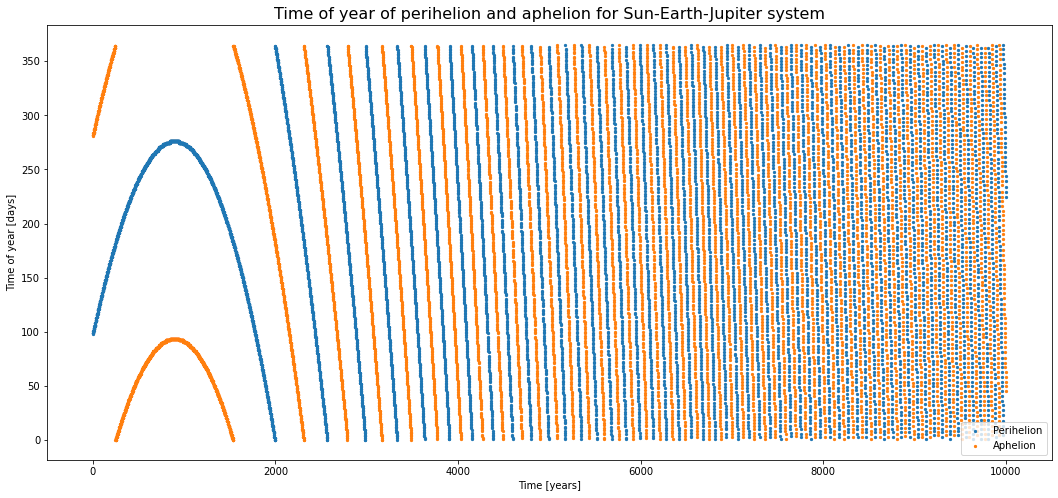

In [68]:
Earth_sun_dist = norm_batch(X_earth-X_sun)

#Compute the indices of x_earth and t at which aphelia and perihelia occur
Aph_indices = find_peaks(Earth_sun_dist)[0]
Peri_indices = find_peaks(-Earth_sun_dist)[0]

#Plot the time of year of aphelia and perihelia as a function of time
plt.figure(figsize=(18,8))
plt.scatter(T[Peri_indices]/seconds_per_year, np.mod(T[Peri_indices], seconds_per_year)/seconds_per_year*365.2422, s=5)
plt.scatter(T[Aph_indices]/seconds_per_year, np.mod(T[Aph_indices], seconds_per_year)/seconds_per_year*365.2422, s=5)
plt.xlabel('Time [years]')
plt.ylabel('Time of year [days]')
plt.title('Time of year of perihelion and aphelion for Sun-Earth-Jupiter system', fontsize=16)
plt.legend(('Perihelion','Aphelion'))

### Eccentricity:
Computation is the same as in the Earth-Sun system.

Text(0.5, 1.0, "Eccentricity of Earth's orbit around the Sun for the Earth-Sun-Jupiter system over a reduced time period")

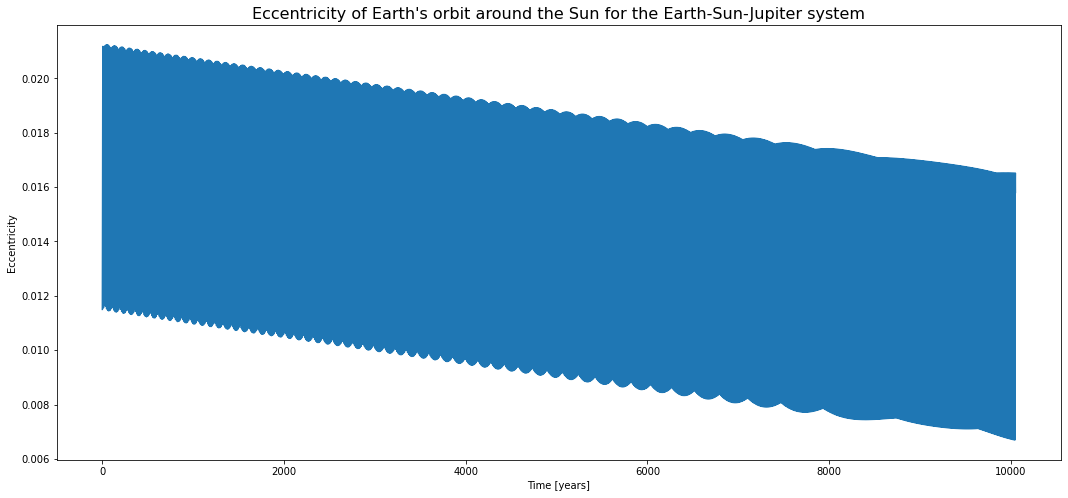

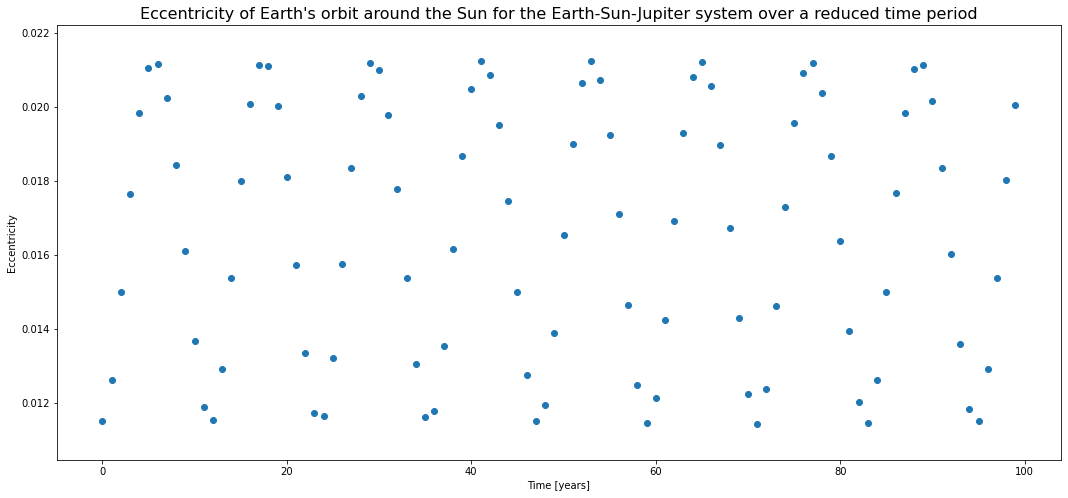

In [69]:
Earth_focus_dist = norm_batch(X_earth)

#Find the indices giving apoapsides and periapsides in X_earth
Apoapsis_indices = find_peaks(Earth_focus_dist)[0]
Periapsis_indices = find_peaks(-Earth_focus_dist)[0]

#Sometimes apoapsis_indices and periapsis_indices differ in length by one, but they need to be the same length to compute eccentricity
if len(Apoapsis_indices) != len(Periapsis_indices):
    if len(Apoapsis_indices) > len(Periapsis_indices):
        Apoapsis_indices = Apoapsis_indices[:-1]
    else:
        Periapsis_indices = Periapsis_indices[:-1]

#Radii at apoapsis (furthest distance from center of mass) and periapsis (closest distance)
R_ap = norm_batch(X_earth[Apoapsis_indices])
R_peri = norm_batch(X_earth[Periapsis_indices])

#Compute the eccentricity
Eccentricity = (R_ap - R_peri)/(R_ap + R_peri)

#Plot the eccentricity
plt.figure(figsize=(18,8))
plt.plot(range(len(Eccentricity)), Eccentricity)
Data_range = max(Eccentricity) - min(Eccentricity)
plt.ylim(min(Eccentricity) - 0.05*Data_range, max(Eccentricity) + 0.05*Data_range)
plt.xlabel('Time [years]')
plt.ylabel('Eccentricity')
plt.title('Eccentricity of Earth\'s orbit around the Sun for the Earth-Sun-Jupiter system', fontsize=16)

#Plot the eccentricity over a reduced time period to see the oscillatory behaviour
plt.figure(figsize=(18,8))
Ecc_reduced = Eccentricity[:100]
plt.scatter(range(len(Ecc_reduced)), Ecc_reduced)
Data_range = max(Ecc_reduced) - min(Ecc_reduced)
plt.ylim(min(Ecc_reduced) - 0.1*Data_range, max(Ecc_reduced) + 0.1*Data_range)
plt.xlabel('Time [years]')
plt.ylabel('Eccentricity')
plt.title('Eccentricity of Earth\'s orbit around the Sun for the Earth-Sun-Jupiter system over a reduced time period', fontsize=16)

### Solar-energy flux:
Computation is the same as in the Earth-Sun system.

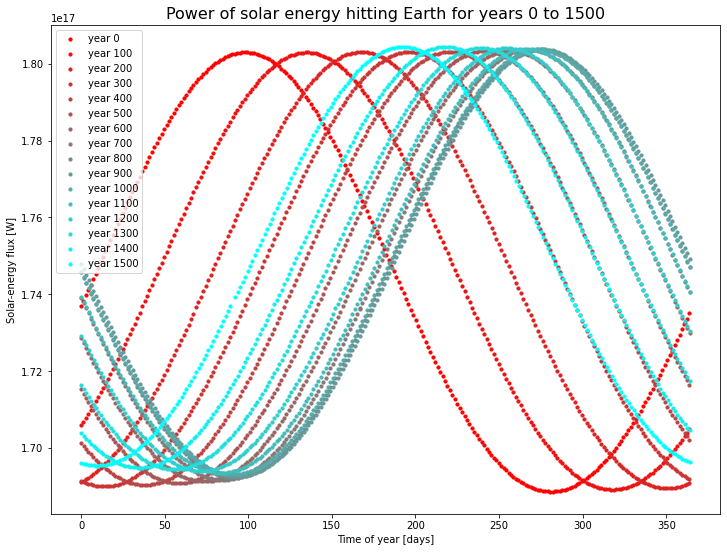

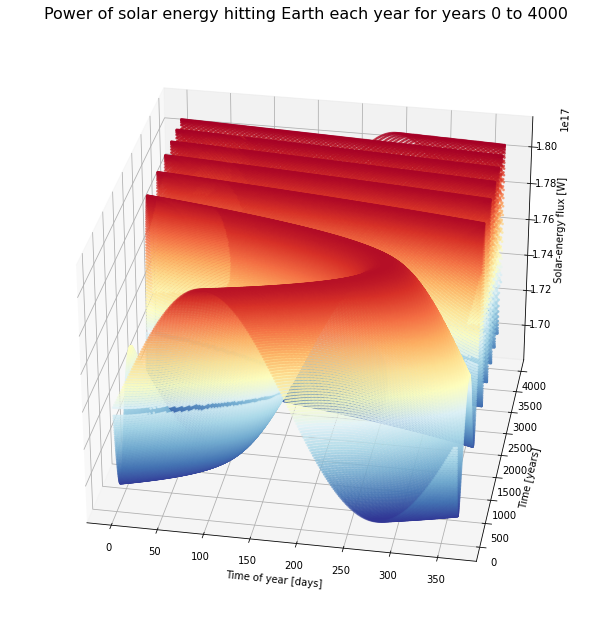

In [70]:
#Split the position vectors of the earth and sun into batches, one batch for each orbit
Iterator = range(len(T_orbit_indices)-1)
X_earth_split_by_orbit = [X_earth[T_orbit_indices[i]:T_orbit_indices[i+1]] for i in Iterator]
X_sun_split_by_orbit = [X_sun[T_orbit_indices[i]:T_orbit_indices[i+1]] for i in Iterator]
T_split_by_orbit = [T[T_orbit_indices[i]:T_orbit_indices[i+1]] for i in Iterator]

#Function to plot multiple years of flux on a 2d scatter-plot
def plot_flux_2d(start_year, end_year, n_plots):
    years_to_compute_flux = np.linspace(start_year,end_year,n_plots, dtype=int)

    plt.figure(figsize=(12,9))
    for i in years_to_compute_flux:
        Earth_sun_dist = norm_batch(X_earth_split_by_orbit[i] - X_sun_split_by_orbit[i])
        #Compute the flux over the entire earth (Area = pi*R^2)
        SEFlux_earth = SEflux(Earth_sun_dist, np.pi*earth_radius**2)
        Xdata = np.mod(T_split_by_orbit[i], seconds_per_year)/seconds_per_year*365.2422
        #Define a number to shift the color of the plots in time
        c_num = (i-start_year)/(end_year-start_year)
        #Plot the flux vs time of year on a scatter-plot
        plt.scatter(Xdata, SEFlux_earth, s=10, c=[[1-c_num,c_num,c_num]])
    plt.legend(['year ' + str(i) for i in years_to_compute_flux])
    plt.xlabel('Time of year [days]')
    plt.ylabel('Solar-energy flux [W]')
    plt.title('Power of solar energy hitting Earth for years %d to %d' % (start_year,end_year), fontsize=16)

plot_flux_2d(0,1500,16)    

#Function to plot a 3d plot of flux over time
def plot_flux_3d(start_year,end_year,year_step):

    #Compute the flux
    X, Z = [], []
    for i in range(start_year,end_year):
        #X coordinate is the time of year in days
        X.append(np.mod(T_split_by_orbit[i], seconds_per_year)/seconds_per_year*365.2422)
        Earth_sun_dist = norm_batch(X_earth_split_by_orbit[i] - X_sun_split_by_orbit[i])
        #Z coordinate is the flux
        Z.append(SEflux(Earth_sun_dist, np.pi*earth_radius**2))
        
    #Make sure the lenghts of all elements of X and Z are the same
    minlen = min([len(x) for x in X] + [len(z) for z in Z])
    X = np.array([x[:minlen] for x in X])
    Z = np.array([z[:minlen] for z in Z])

    #Create colour map for the 3d plot where points are coloured by z-value
    cm = plt.get_cmap("RdYlBu_r")
    maxz = max(Z.flatten())
    minz = min(Z.flatten())
    col = cm((Z-minz)/(maxz-minz))

    #Plot the flux in 3D
    fig = plt.figure(figsize=(14,11))
    ax = fig.add_subplot(projection='3d')
    for i in range(0,len(X),year_step):
        ax.scatter(X[i], (i+start_year)*np.ones(len(X[i])), Z[i], s=3, c=col[i], alpha=0.6)
    ax.set_xlabel('Time of year [days]')
    ax.set_ylabel('Time [years]')
    ax.set_zlabel('Solar-energy flux [W]')
    ax.set_title('Power of solar energy hitting Earth each year for years %d to %d' % (start_year,end_year), fontsize=16)
    
    #Set the viewing angle of the 3d plot
    ax.view_init(elev=30, azim=-80)
    
plot_flux_3d(0,4000,4)

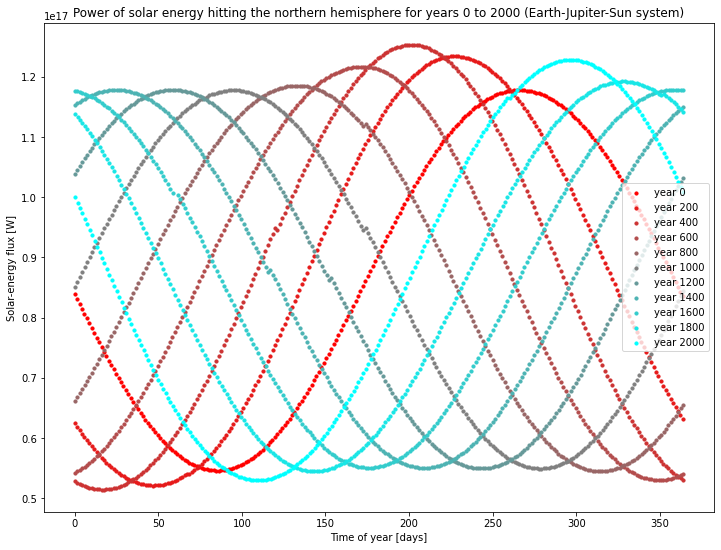

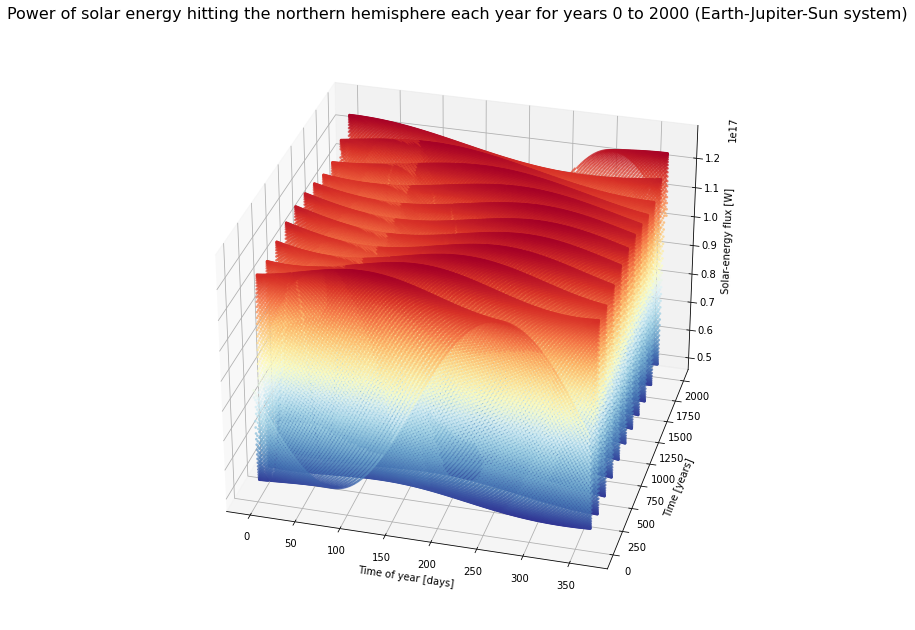

In [72]:
#Angle of Earth's axis toward or away from the sun
#Over the course of one orbit, this oscillates between +axial_tilt and -axial_tilt
Angle_freq = 2*np.pi/Mean_orbital_period
Phi = np.pi - Angle_freq*t_ws #Calculated to satisfy axis_angle(t_ws) = -axial_tilt(t_ws) where t_ws is the time at winter solstice
def Axis_angle(t):
    return axial_tilt(t)*np.cos(Angle_freq*t + Phi)

#Function to plot multiple years of flux on a 2d scatter-plot
def plot_flux_2d(start_year, end_year, n_plots):
    years_to_compute_flux = np.linspace(start_year,end_year,n_plots, dtype=int)

    plt.figure(figsize=(12,9))
    for i in years_to_compute_flux:
        Earth_sun_dist = norm_batch(X_earth_split_by_orbit[i] - X_sun_split_by_orbit[i])
        #Compute the flux over the northern hemisphere (Area = 0.5*(1+sin(theta))*pi*R^2)
        SEFlux_nh = SEflux(Earth_sun_dist, 0.5*(1+np.sin(Axis_angle(T_split_by_orbit[i])))*np.pi*earth_radius**2)
        Xdata = np.mod(T_split_by_orbit[i], seconds_per_year)/seconds_per_year*365.2422
        #Define a number to shift the color of the plots in time
        c_num = (i-start_year)/(end_year-start_year)
        #Plot the flux vs time of year on a scatter-plot
        plt.scatter(Xdata, SEFlux_nh, s=10, c=[[1-c_num,c_num,c_num]])
    plt.legend(['year ' + str(i) for i in years_to_compute_flux])
    plt.xlabel('Time of year [days]')
    plt.ylabel('Solar-energy flux [W]')
    plt.title('Power of solar energy hitting the northern hemisphere for years %d to %d (Earth-Jupiter-Sun system)' % (start_year,end_year), fontsize=12)

plot_flux_2d(0,2000,11)

#Function to plot a 3d plot of flux over time
def plot_flux_3d(start_year,end_year,year_step):

    #Compute the flux
    X, Z = [], []
    for i in range(start_year,end_year):
        #X coordinate is the time of year in days
        X.append(np.mod(T_split_by_orbit[i], seconds_per_year)/seconds_per_year*365.2422)
        Earth_sun_dist = norm_batch(X_earth_split_by_orbit[i] - X_sun_split_by_orbit[i])
        #Z coordinate is the flux
        Z.append(SEflux(Earth_sun_dist, 0.5*(1+np.sin(Axis_angle(T_split_by_orbit[i])))*np.pi*earth_radius**2))
    
    #Make sure the lenghts of all elements of X and Z are the same
    minlen = min([len(x) for x in X] + [len(z) for z in Z])
    X = np.array([x[:minlen] for x in X])
    Z = np.array([z[:minlen] for z in Z])

    #Create colour map for the 3d plot where points are coloured by z-value
    cm = plt.get_cmap("RdYlBu_r")
    maxz = max(Z.flatten())
    minz = min(Z.flatten())
    col = cm((Z-minz)/(maxz-minz))

    #Plot the flux in 3D
    fig = plt.figure(figsize=(14,11))
    ax = fig.add_subplot(projection='3d')
    for i in range(0,len(X),year_step):
        ax.scatter(X[i], (i+start_year)*np.ones(len(X[i])), Z[i], s=3, c=col[i], alpha=0.6)
    ax.set_xlabel('Time of year [days]')
    ax.set_ylabel('Time [years]')
    ax.set_zlabel('Solar-energy flux [W]')
    ax.set_title('Power of solar energy hitting the northern hemisphere each year for years %d to %d (Earth-Jupiter-Sun system)' % (start_year,end_year), fontsize=16)
    
    #Set the viewing angle of the 3d plot
    ax.view_init(elev=30, azim=-75)
    
plot_flux_3d(0,2000,2)